In [1]:
using  FFTW
using  LinearAlgebra
using  ProgressMeter
using  BenchmarkTools
using  Plots
pyplot()

Plots.PyPlotBackend()

Paramètres du système

In [2]:
epsilon=1/2
N=2^12
L=10
T=5
dt=0.001
@show epsilon,N,L,T,dt;

(epsilon, N, L, T, dt) = (0.5, 4096, 10, 5, 0.001)


Initialisation : grilles en espace, fréquence, temps

In [3]:
include("mesh.jl")
include("times.jl")
include("freq.jl")
include("fig.jl")

mesh = Mesh(-L, L, N);
freq = Freq(mesh.dx, N);
times = Times(dt, T);

Quelques multiplicateurs de Fourier

In [4]:
Gamma=abs.(freq.k); # Lambda, "absolute differentiation"
H=-1im.*sign.(freq.k); # Hilbert transform
Dx=1im*freq.k; # Differentiation
Pi=Gamma.<freq.kmax*2/3; # Dealiasing low-pass filter

Donnée initiale

In [5]:
h0=exp.(-mesh.x.^2);
h0hat=Pi.*fft(h0);
u0=zeros(N);
u0hat=Pi.*fft(u0);

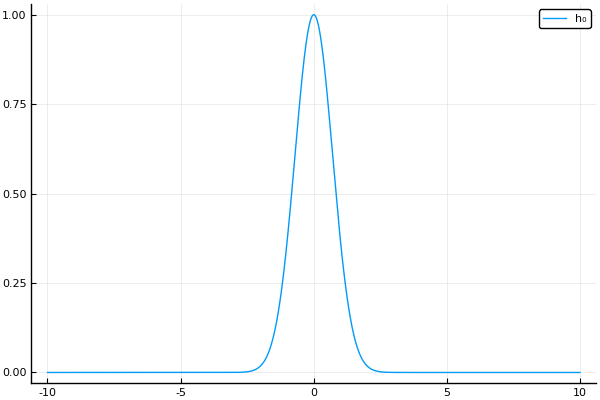

In [6]:
plot(mesh.x,h0,label="h₀")

Systèmes à résoudre : d_t U=F(U)

In [7]:
#=
# WW2
function FWW2(hhat,uhat)
    h=real(ifft(hhat))
    u=real(ifft(uhat))
    Hu=real(ifft(H.*uhat))
    return (H.*uhat-epsilon*Pi.*(Gamma.*fft(h.*Hu)+Dx.*fft(h.*u)),-(Dx.*hhat)-epsilon/2*Pi.*Dx.*fft(u.^2-Hu.^2))
end
#@btime FWW2(h0hat,u0hat);
=#
# Cheng et al
function Fwave_naive(hhat,uhat)
    h=ifft(hhat);
    Int1=H.*fft(ifft(Gamma.*uhat).^2);
    Int2=fft(h.*ifft(Dx.*hhat)) ;
    Int3=H.*fft(h.*ifft(Gamma.*hhat));
    return (-(Dx.*uhat),H.*hhat+epsilon*Pi.*(Int1-Int2-Int3))
end
@benchmark Fwave_naive(h0hat,u0hat)

#=
# Matsuno  
function Matsuno(hhat,uhat)
    h=real(ifft(hhat))
    u=real(ifft(uhat))
    Int4=fft(real(ifft(Dx.*hhat)).*real(ifft(Gamma.*hhat)))
    return (H.*uhat-epsilon*Pi.*(H.*fft(h.*real(ifft(Gamma.*uhat)))+Dx.*fft(h.*u)),-(Dx.*hhat)-epsilon/2*Pi.*(Dx.*fft(u.^2))+epsilon*Pi.*Int4)
end    
#@btime Matsuno(h0hat,u0hat);

# Saut-Xu
function SautXu(hhat,uhat)
    h=real(ifft(hhat))
    u=real(ifft(uhat))
    Dh=real(ifft(Dx.*hhat))
    Du=real(ifft(Dx.*uhat))
    Gu=real(ifft(Gamma.*uhat))
    Gh=real(ifft(Gamma.*hhat))
    return (H.*uhat-epsilon*Pi.*(fft(u.*Dh/2+h.*Du)+H.*fft(h.*Gu+u.*Gh/2)),-(Dx.*hhat)-epsilon*Pi.*(Dx.*fft(u.^2)-fft(Dh.*Gh)/2))
end  
#btime SautXu(h0hat,u0hat);

# WW2 modifié (prime)
function FWW2p(hhat,uhat)
    h=real(ifft(hhat))
    u=real(ifft(uhat))
    Hu=real(ifft(H.*uhat))
    Dth=H.*uhat-epsilon*Pi.*(Gamma.*fft(h.*Hu)+Dx.*fft(h.*u))
    return (Dth,-Dx.*hhat-epsilon/2*Pi.*Dx.*fft(u.^2-real(ifft(Dth).^2)))
end
#@btime FWW2p(h0hat,u0hat);
=#

BenchmarkTools.Trial: 
  memory estimate:  1.43 MiB
  allocs estimate:  462
  --------------
  minimum time:     477.706 μs (0.00% GC)
  median time:      579.792 μs (0.00% GC)
  mean time:        843.037 μs (21.99% GC)
  maximum time:     5.098 ms (81.46% GC)
  --------------
  samples:          5909
  evals/sample:     1

In [8]:
Px=plan_fft(h0hat);
function Fwave_plan(hhat,uhat)
    h = Px \ copy(hhat);
    Int1=copy(uhat);Int1.*=Gamma; dum = Px \ Int1; dum.^=2; Int1 .= Px * dum; Int1.*=H; 
    #@PNavaro : pourquoi dum .= Px \ Int1; (avec le point) produit plus d'allocations ?
    Int2=copy(hhat);Int2.*=Dx; dum = Px \ Int2; dum.*=h; Int2 .= Px * dum;
    Int3=copy(hhat);Int3.*=Gamma; dum = Px \ Int3; dum.*=h; Int3 .= Px * dum; Int3.*=H;
    nhhat=-copy(uhat);nhhat.*=Dx;
    Int1.-=Int2;Int1.-=Int3;Int1.*=Pi;Int1.*=epsilon;
    nuhat=copy(hhat);nuhat.*=H;nuhat.+=Int1;
    return (nhhat,nuhat)
end
@benchmark Fwave_plan(h0hat,u0hat)


BenchmarkTools.Trial: 
  memory estimate:  898.48 KiB
  allocs estimate:  73
  --------------
  minimum time:     310.645 μs (0.00% GC)
  median time:      415.710 μs (0.00% GC)
  mean time:        572.455 μs (19.32% GC)
  maximum time:     6.352 ms (77.04% GC)
  --------------
  samples:          8673
  evals/sample:     1

In [9]:
#h=copy(h0hat);dum=copy(u0hat);Int1=copy(u0hat);Int2=copy(u0hat);Int3=copy(u0hat);nhhat=copy(u0hat);nuhat=copy(u0hat);
function Fwave_prealloc(hhat,uhat)
    #global h, dum, Int1, Int2, Int3, nhhat, nuhat
    dum=similar(hhat); 
    #@PNavaro : je voudrais faire cette allocation (et d'autres) en dehors de la fonction (en utilisant global ? en ajoutant une variable ?), mais je n'arrive pas à le faire avec un gain de temps substantiel
    h = Px \ copy(hhat);
    Int1=copy(uhat);Int1.*=Gamma; ldiv!(dum , Px , Int1); dum.^=2; mul!(Int1 , Px , dum); Int1.*=H; 
    Int2=copy(hhat);Int2.*=Dx; ldiv!(dum , Px , Int2); dum.*=h; mul!(Int2 , Px , dum);
    Int3=copy(hhat);Int3.*=Gamma; ldiv!(dum,Px,Int3); dum.*=h; mul!(Int3 , Px , dum); Int3.*=H;
    nhhat=-copy(uhat);nhhat.*=Dx;
    Int1-=Int2;Int1.-=Int3;Int1.*=Pi;Int1.*=epsilon;
    nuhat=copy(hhat);nuhat.*=H;nuhat.+=Int1;
    return (nhhat,nuhat)
end
@benchmark Fwave_prealloc(h0hat,u0hat)

BenchmarkTools.Trial: 
  memory estimate:  642.02 KiB
  allocs estimate:  55
  --------------
  minimum time:     309.923 μs (0.00% GC)
  median time:      428.329 μs (0.00% GC)
  mean time:        566.481 μs (16.06% GC)
  maximum time:     5.716 ms (89.66% GC)
  --------------
  samples:          8724
  evals/sample:     1

Intégration en temps : RK4 (remplace la donnée)

In [10]:
function RK4!(h,u,F,dt)
    (h1,u1) =F(h,u)
    (h2,u2) =F(h+dt/2*h1,u+dt/2*u1)
    (h3,u3) =F(h+dt/2*h2,u+dt/2*u2)
    (h4,u4) =F(h+dt*h3,u+dt*u3)
    h.+=dt/6*(h1+2*h2+2*h3+h4)
    u.+=dt/6*(u1+2*u2+2*u3+u4)
end
#@btime RK4!(h0hat,u0hat,Fwave,dt);

wrap-up : intégration sur tous les pas de temps, écriture sur la donnée Us

In [11]:
Us=[];Modeles=[];
function solve(U0,F,times)
    h=copy(U0[1]);u=copy(U0[2])
    push!(Us,zeros(Complex{Float64},(mesh.nx,2,times.nt)))
    (Us[end][:,1,1],Us[end][:,2,1])=(h,u)
    prog = Progress(times.nt,1) # progress bar
    for l in range(1,times.nt-1)
        dt=times.t[l+1]-times.t[l]
        #Compute one time step
        RK4!(h,u,F,dt)
        
        #Store
        (Us[end][:,1,l+1],Us[end][:,2,l+1])=(h,u)
            
        next!(prog) # increment the progress bar
    end
end

solve (generic function with 1 method)

Finalement les calculs : version naive, puis fft_plan, puis prealloc

In [12]:
#print("*** Calculs WW2 ***")
#push!(Modeles,"WW2")
#@time solve((h0hat,u0hat),FWW2,times);

In [13]:
#print("*** Calculs Cheng et al. ***")
push!(Modeles,"Cheng et al. version naive")
@time solve((h0hat,u0hat),Fwave_naive,times);

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:01

 21.973503 seconds (12.43 M allocations: 34.805 GiB, 22.97% gc time)


In [14]:
#print("*** Calculs Cheng et al. ***")
push!(Modeles,"Cheng et al. version fft_plan")
@time solve((h0hat,u0hat),Fwave_plan,times);

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

 14.912928 seconds (1.84 M allocations: 23.865 GiB, 23.08% gc time)


In [15]:
#print("*** Calculs Cheng et al. ***")
push!(Modeles,"Cheng et al. version prealloc")
@time solve((h0hat,u0hat),Fwave_prealloc,times);

Progress:  94%|██████████████████████████████████████   |  ETA: 0:00:01

 13.139512 seconds (1.47 M allocations: 18.973 GiB, 20.71% gc time)


In [16]:
#print("*** Calculs Matsuno ***")
#push!(Modeles,"Matsuno")
#@time solve((h0hat,u0hat),Matsuno,times);

In [17]:
#print("*** Calculs Saut-Xu ***")
#push!(Modeles,"Saut-Xu")
#@time solve((h0hat,u0hat),SautXu,times);

In [18]:
#print("*** Calculs WW2 modifié ***")
#push!(Modeles,"WW2 modifié")
#@time solve((h0hat,u0hat),FWW2p,times);

Graphiques

In [19]:
Labels=reshape(copy(Modeles),(1,length(Modeles)))


1×3 Array{Any,2}:
 "Cheng et al. version naive"  …  "Cheng et al. version prealloc"

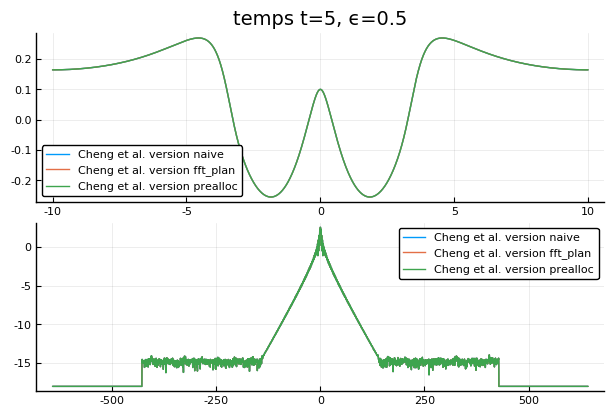

In [20]:
fig(5)
#@PNavaro : Sais-tu comment afficher des plots interactifs ? (=possibilité de zoomer, bouton pour sauvegarder)

In [21]:
norm(Us[2][:,:,:]-Us[1][:,:,:]),norm(Us[3][:,:,:]-Us[1][:,:,:],Inf)
#@PNavaro : C'est possible qu'il n'y ait *aucune* différence entre deux simulations ?

(0.0, 0.0)